# CIFAR-10 Image Classification Using ResNet (PyTorch Backend)
In this example we are going to demonstrate how to train a CIFAR-10 image classification model using a ResNet architecture on the PyTorch backend. All training details including model structure, data preprocessing, learning rate control, etc. come from https://github.com/davidcpage/cifar10-fast. Note that we will, however, be using the ciFAIR-10 dataset which fixes train/test duplicates found in the original CIFAR-10 dataset (https://cvjena.github.io/cifair/)

## Import the required libraries

In [1]:
import fastestimator as fe
import numpy as np
import matplotlib.pyplot as plt
import tempfile

from fastestimator.util import BatchDisplay, GridDisplay

In [2]:
#training parameters
epochs = 24
batch_size = 512
train_steps_per_epoch = None
eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

## Step 1 - Data and `Pipeline` preparation
In this step, we will load ciFAIR-10 training and validation datasets and prepare FastEstimator's pipeline.

### Load dataset 
We use a FastEstimator API to load the ciFAIR-10 dataset and then get a test set by splitting 50% of the data off of the evaluation set. 

In [3]:
from fastestimator.dataset.data import cifair10

train_data, eval_data = cifair10.load_data()
test_data = eval_data.split(0.5)

### Set up a pre-processing `Pipeline`
Here we set up the data pipeline. This will involve a variety of data augmentation including: random cropping, horizontal flipping, image obscuration, and smoothed one-hot label encoding. Beside all of this, the image channels need to be transposed from HWC to CHW format due to PyTorch conventions. We set up these processing steps using `Ops` and also bundle the data sources and batch_size together into our `Pipeline`.

In [4]:
from fastestimator.op.numpyop.univariate import ChannelTranspose, CoarseDropout, Normalize, Onehot
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop

pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[
        Normalize(inputs="x", outputs="x_out", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
        PadIfNeeded(min_height=40, min_width=40, image_in="x_out", image_out="x_out", mode="train"),
        RandomCrop(32, 32, image_in="x_out", image_out="x_out", mode="train"),
        Sometimes(HorizontalFlip(image_in="x_out", image_out="x_out", mode="train")),
        CoarseDropout(inputs="x_out", outputs="x_out", mode="train", max_holes=1),
        ChannelTranspose(inputs="x_out", outputs="x_out"),
        Onehot(inputs="y", outputs="y_out", mode="train", num_classes=10, label_smoothing=0.2)
    ])

### Validate `Pipeline`
In order to make sure the `Pipeline` works as expected, let's visualize the output and check its size. `Pipeline.get_results` will return a batch data of pipeline output for this purpose:

In [5]:
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]
data_yin = data["y"]
data_yout = data["y_out"]

print("the pipeline input image size: {}".format(data_xin.numpy().shape))
print("the pipeline output image size: {}".format(data_xout.numpy().shape))
print("the pipeline input label size: {}".format(data_yin.numpy().shape))
print("the pipeline output label size: {}".format(data_yout.numpy().shape))

the pipeline input image size: (512, 32, 32, 3)
the pipeline output image size: (512, 3, 32, 32)
the pipeline input label size: (512, 1)
the pipeline output label size: (512, 10)


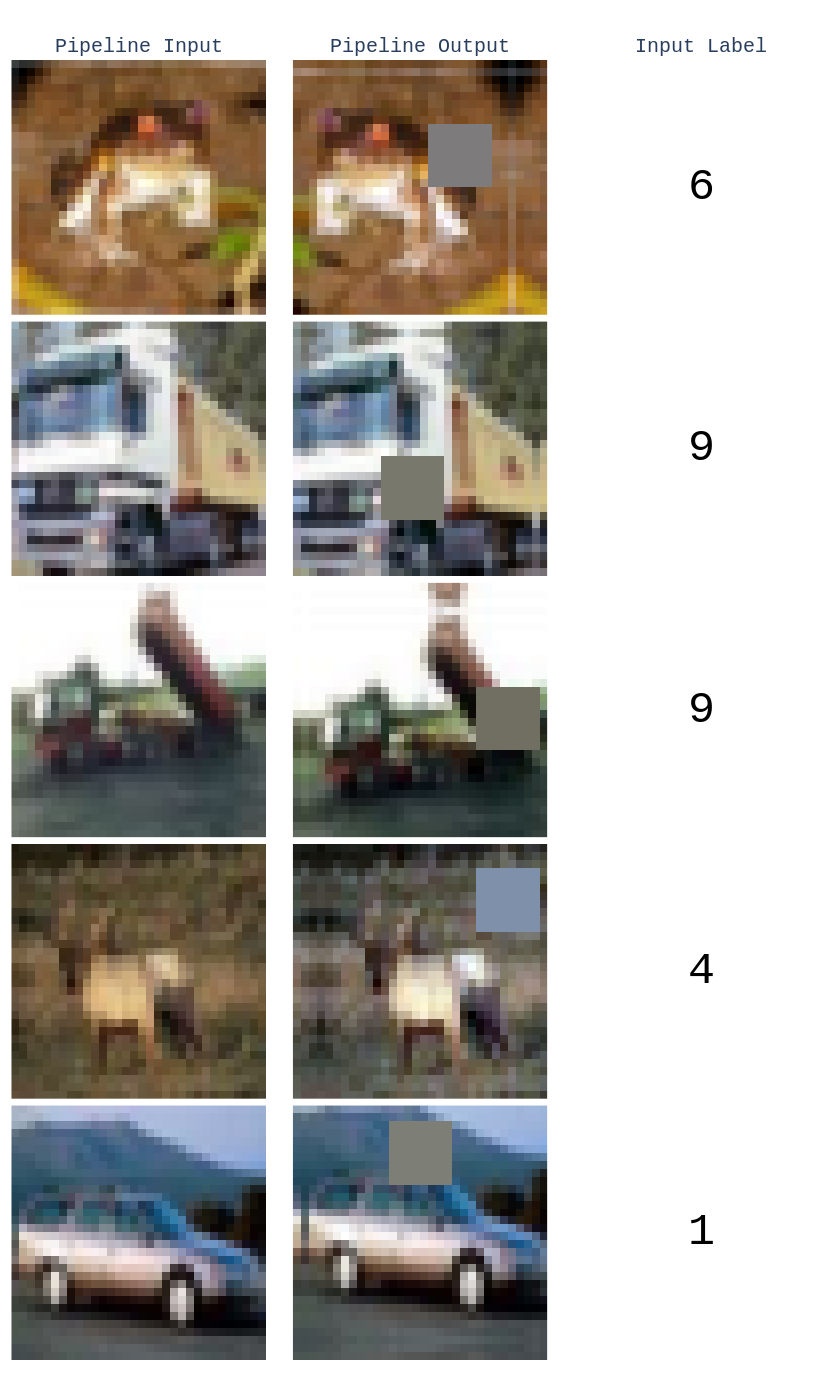

In [6]:
sample_num = 5

fig = GridDisplay([BatchDisplay(image=data_xin[0:sample_num], title="Pipeline Input"), 
                   BatchDisplay(image=data_xout[0:sample_num], title="Pipeline Output"),
                   BatchDisplay(text=data_yin[0:sample_num], title="Input Label"),
                  ])
fig.show()

## Step 2 - `Network` construction
**FastEstimator supports both PyTorch and TensorFlow, so this section could use either backend.** <br>
We are going to only demonstrate the PyTorch way in this example.

### Model construction
The model definitions are implemented in PyTorch and instantiated by calling `fe.build` which also associates the model with a specific optimizer. Here we are going to directly import the model architecture from FastEstimator.

In [7]:
from fastestimator.architecture.pytorch import ResNet9

model = fe.build(model_fn=ResNet9, optimizer_fn="adam")

### `Network` definition
`Ops` are the basic components of a network that include models, loss calculation units, and post-processing units. In this step we are going to combine those pieces together into a `Network`:  

In [8]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

network = fe.Network(ops=[
        ModelOp(model=model, inputs="x_out", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y_out"), outputs="ce", mode="train"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce", mode="test"),
        UpdateOp(model=model, loss_name="ce", mode="train")
    ])

## Step 3 - `Estimator` definition and training
In this step, we define an `Estimator` to connect our `Network` with our `Pipeline` and set the `traces` which will compute accuracy (`Accuracy`), save our best model (`BestModelSaver`), and change the learning rate (`LRScheduler`) of our optimizer over time. We will then use `Estimator.fit` to trigger the training.

In [9]:
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy

def lr_schedule(step):
    if step <= 490:
        lr = step / 490 * 0.4
    else:
        lr = (2352 - step) / 1862 * 0.4
    return lr * 0.1

traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="accuracy", save_best_mode="max"),
    LRScheduler(model=model, lr_fn=lr_schedule)
]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch)

estimator.fit() # start the training 

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 1;
FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace o

FastEstimator-Warn: the key 'y' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.

FastEstimator-Warn: the key 'y' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or

FastEstimator-Train: step: 1078; epoch: 11; epoch_time: 6.32 sec;
Eval Progress: 1/9;
Eval Progress: 3/9; steps/sec: 58.97;
Eval Progress: 6/9; steps/sec: 60.72;
Eval Progress: 9/9; steps/sec: 69.84;
FastEstimator-BestModelSaver: Saved model to /tmp/tmpwe5altag/model_best_accuracy.pt
FastEstimator-Eval: step: 1078; epoch: 11; accuracy: 0.8898; max_accuracy: 0.8898; since_best_accuracy: 0;
FastEstimator-Train: step: 1100; ce: 1.0599289; model_lr: 0.026895812; steps/sec: 15.54;
FastEstimator-Train: step: 1176; epoch: 12; epoch_time: 6.34 sec;
Eval Progress: 1/9;
Eval Progress: 3/9; steps/sec: 61.15;
Eval Progress: 6/9; steps/sec: 65.76;
Eval Progress: 9/9; steps/sec: 67.85;
FastEstimator-Eval: step: 1176; epoch: 12; accuracy: 0.872; max_accuracy: 0.8898; since_best_accuracy: 1;
FastEstimator-Train: step: 1200; ce: 1.0239849; model_lr: 0.024747584; steps/sec: 15.93;
FastEstimator-Train: step: 1274; epoch: 13; epoch_time: 6.24 sec;
Eval Progress: 1/9;
Eval Progress: 3/9; steps/sec: 61.75;


## Model testing
`Estimator.test` will trigger model testing using all of the test data defined in the `Pipeline`. This will allow us to check our accuracy on previously unseen data.

In [10]:
estimator.test()

FastEstimator-Test: step: 2352; epoch: 24; accuracy: 0.9342; ce: 0.38099137;


## Inferencing
In this step we run image inference directly using the model that we just trained. We randomly select 5 images from testing dataset and infer them image by image using `Pipeline.transform` and `Network.transform`. Please be aware that the `Pipeline` is no longer the same as it was during training, because we don't want to use data augmentation during inference. This detail was already defined in the `Pipeline` (mode = "!infer"). 

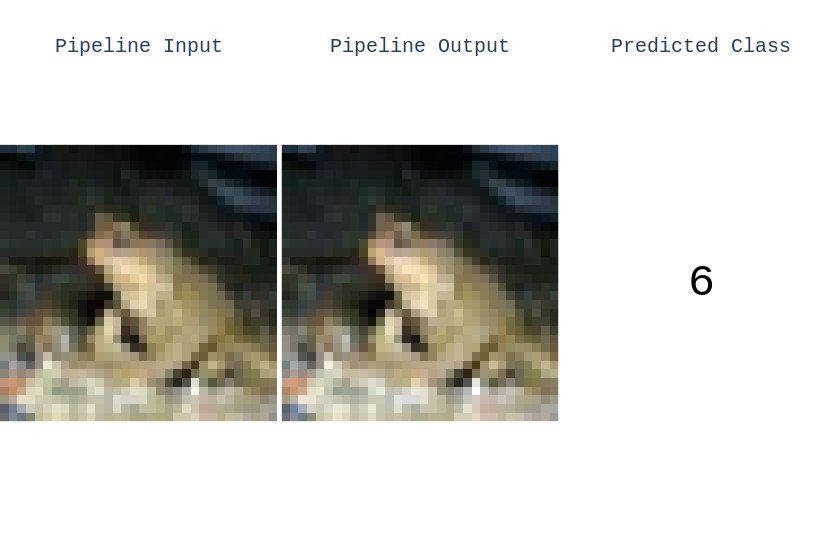

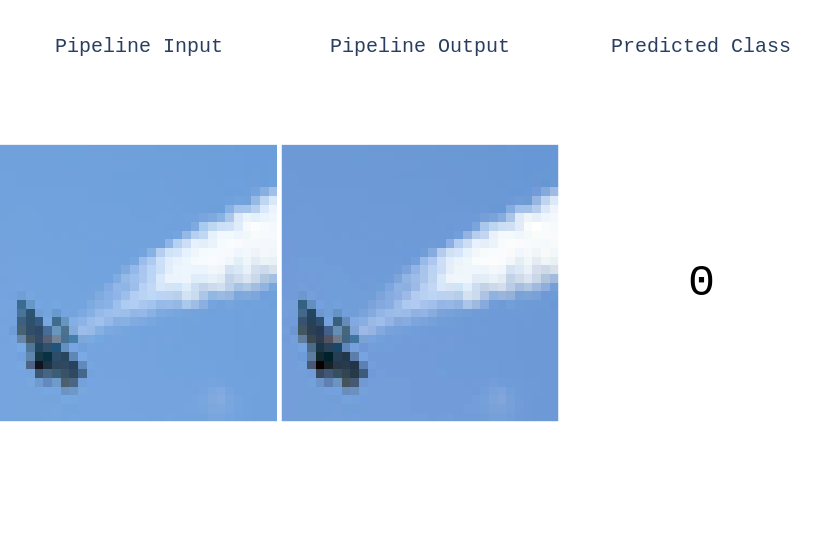

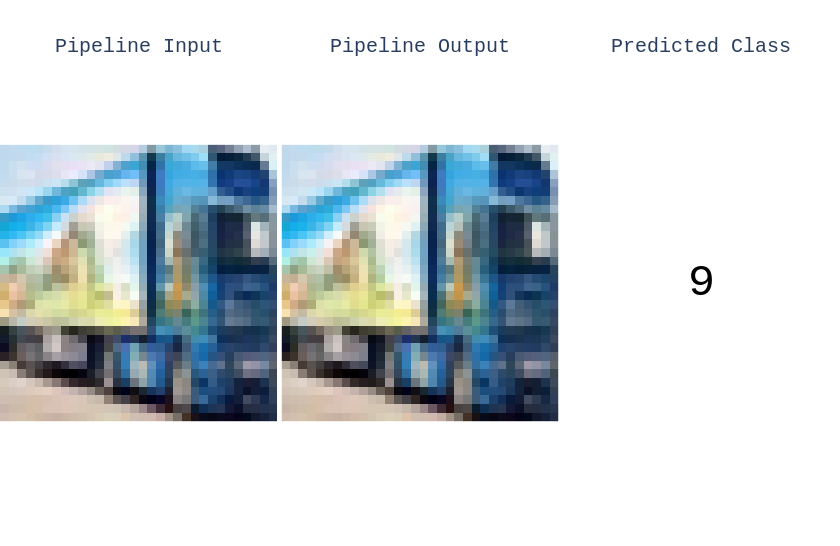

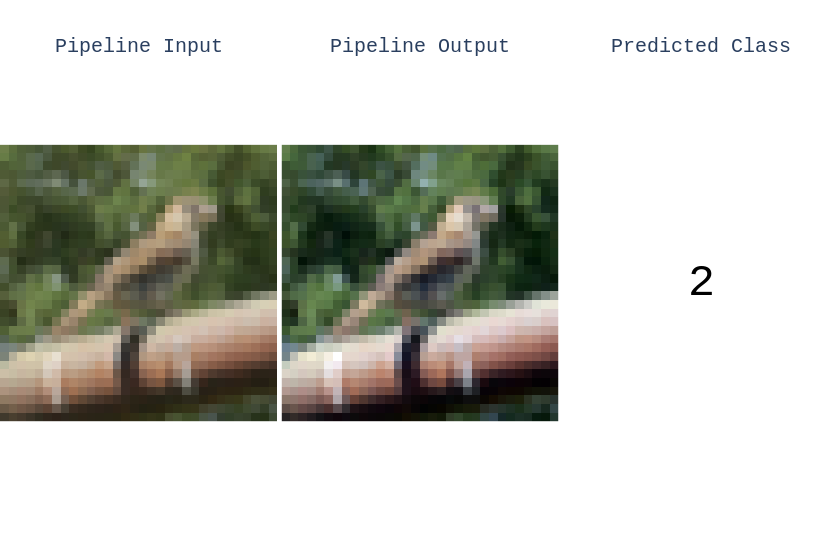

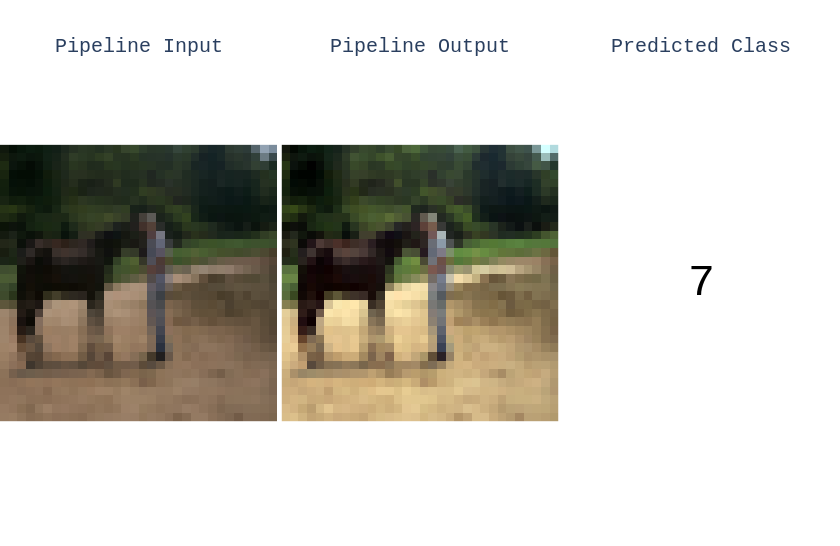

In [11]:
sample_num = 5

for i, j in enumerate(np.random.randint(low=0, high=batch_size-1, size=sample_num)):
    data = {"x": test_data["x"][j]}
    
    # run the pipeline
    data = pipeline.transform(data, mode="infer") 
    
    # run the network
    data = network.transform(data, mode="infer")
    predict = data["y_pred"].numpy()
    
    fig = GridDisplay([BatchDisplay(image=data['x'], title="Pipeline Input"),
                       BatchDisplay(image=data["x_out"], title="Pipeline Output"),
                       BatchDisplay(text=[np.argmax(predict)], title="Predicted Class")
                      ])
    fig.show()